In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
DATA_DIR = os.path.abspath('../state_data')
FIG_DIR = os.path.abspath('../figures')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from utils.energy_tools import read_region

%matplotlib inline

In [2]:
file_st = f"{DATA_DIR}" + "/" + "states_info.csv"
df_states = pd.read_csv(file_st, index_col = 0, parse_dates = ['LD'])

In [3]:
df_states.loc['NY']

NAME                            New York
LD                   2020-03-22 00:00:00
CAL                                  NaN
CAR                                  NaN
CENT                                 NaN
FLA                                  NaN
MIDA                                 NaN
MIDW                                 NaN
NE                                   NaN
NY                                     1
NW                                   NaN
SE                                   NaN
SW                                   NaN
TEN                                  NaN
TEX                                  NaN
Population                      19453561
Governor                    Andrew Cuomo
Party affiliation       Democratic Party
Name: NY, dtype: object

In [4]:
regions = df_states.columns[2:-3]
states = df_states.index.values

pop_region = {}
pop_under_lockdown = {}
pop_ratio = {}
states_in_region = {}


for region in regions:
    count = 0
    for state in states:
        if not pd.isna(df_states.loc[state][region]): 
            # state is in the region
            count += df_states.loc[state].Population
    pop_region[region] = count/1e6

for region in regions:
    count = 0
    for state in states:
        if (not pd.isna(df_states.loc[state][region])) and (not pd.isna(df_states.loc[state]['LD'])): 
            # state is in the region and is under lockdown as of today
            count += df_states.loc[state].Population
    pop_under_lockdown[region] = count/1e6

for key in pop_region.keys():
    pop_ratio[key] = pop_under_lockdown[key]/pop_region[key]
    
for region in regions:
    state_list = []
    for state in states:
        if not pd.isna(df_states.loc[state][region]):
            # state is in the region
            state_list.append(state)
    states_in_region[region] = state_list


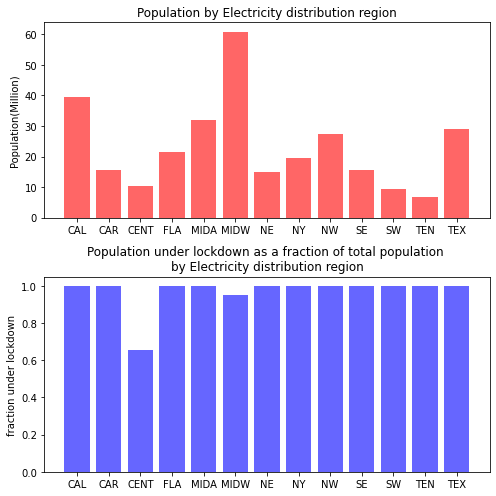

In [5]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(7,7)
ax[0].bar(pop_region.keys(), pop_region.values(), color = 'red', alpha = 0.6)
ax[0].set_ylabel('Population(Million)')
ax[0].set_title('Population by Electricity distribution region')

ax[1].bar(pop_ratio.keys(), pop_ratio.values(), color = 'blue', alpha = 0.6)
ax[1].set_ylabel('fraction under lockdown')
ax[1].set_title('Population under lockdown as a fraction of total population \nby Electricity distribution region')
plt.tight_layout()
plt.show()
                

In [6]:
states_in_region['NW']

['CO', 'ID', 'MT', 'NV', 'OR', 'UT', 'WA', 'WY']

In [7]:
def weighted_temperature(region):
    
    """Takes all the states in the region and generates a population weighted temperature for the region.
    
    The output frame contains 
    index : DATE
    columns : T_(statename)
              T_WA
    """
    
    df_list = []
    states = states_in_region[region]
    
    for state in states:
        filepath_15to19 = f"{DATA_DIR}" + "/" + state + "_2015-2019_raw.csv"
        filepath_2020 = f"{DATA_DIR}" + "/" + state + "_2020_raw.csv"
        T_till_2019 = pd.read_csv(filepath_15to19, index_col = 'DATE', parse_dates = True) #2015-2019 data
        T_2020 = pd.read_csv(filepath_2020, index_col = 'DATE', parse_dates = True) #2020 data
        T_all = T_till_2019.append(T_2020) # 2015-2020 data
        T_all.dropna(inplace = True) #dropping some missing entries
        T_all.rename(columns = {'MEAN_T': f'{state}'}, inplace = True)
        df_list.append(T_all)
   
    df = pd.concat(df_list, axis = 1)
    
    def weighted_average(row):
        """ Calculates Popoulation weighted Average of Temperature. 
        
        Missing Temperature values ignored while calculating weights"""
        
        wm = 0 # weighted mean
        tot_pop = 0 #Population of states with available Temperature data in a particular row
        
        for col in row.index:
            if not pd.isnull(row[col]): 
                wm += row[col]*df_states.loc[col].Population
                tot_pop += df_states.loc[col].Population
        return wm/tot_pop

    df['T_WA'] = df.apply(weighted_average, axis = 1)
    
    df.to_csv(f'{DATA_DIR}' + "/" + f'Regional_{region}_2015-2020.csv') # stores it in a file
    return df

In [8]:
weighted_temperature('NW').sample(15)

,CO,ID,MT,NV,OR,UT,WA,WY,T_WA
DATE,,,,,,,,,
2020-02-01,28.692308,33.307692,36.000000,43.700000,51.500000,28.000000,49.888889,27.125000,40.290262
2015-10-05,55.750000,54.500000,42.153846,61.714286,60.454545,61.000000,58.000000,46.909091,57.591544
2019-11-03,31.611111,35.000000,37.000000,47.500000,44.125000,NaN,40.500000,29.769231,39.084655
2018-10-10,38.777778,45.000000,37.714286,58.500000,52.272727,47.333333,52.583333,35.454545,48.234464
2020-02-25,30.760000,28.307692,28.875000,44.600000,39.833333,33.750000,40.277778,24.857143,36.367319
2017-05-30,58.000000,66.000000,58.750000,74.285714,65.454545,65.500000,67.526316,54.555556,65.004044
2018-06-25,62.833333,65.800000,65.357143,78.250000,69.363636,71.500000,70.666667,57.727273,68.966430
2015-12-12,41.150000,31.800000,29.692308,38.285714,41.727273,34.000000,40.222222,29.909091,38.519818
2016-10-19,50.285714,42.555556,45.000000,51.777778,49.812500,50.000000,50.590909,40.100000,49.503984


In [9]:
# Generate all the Regional temperature files. Only need to run this once.
for region in regions:
    weighted_temperature(region)

In [10]:
def df_for_region(region):
    
    """
    Takes in region as input. Uses the population weighted temperature in that region to
    create dataframes with the following structure: 
    
    index : DATE,
    [23]columns:    
    [04] temperatures to the 4th degree,
    [06] onehotencoded days of the week,
    [11] onehotencoded month,
    [01] Holiday(1 or 0)
    [01] Demand
    
    returns two dataframes df_till_2019 and df_2020 which are seperated by a cutoff date of 2020-01-01
    """
    
    reg_dict = {'CAL' : 'California', 
                'CAR':'Carolinas',
                'CENT': 'Central', 
                'FLA':'Florida',
                'MIDA': 'Mid-Atlantic', 
                'MIDW': 'Midwest',
                'NE': 'New England',  
                'NY': 'New York',
                'NW':'Northwest', 
                'SE': 'Southeast',
                'SW':'Southwest',
                'TEN': 'Tennessee',
                'TEX':'Texas'}
    
    """creates a dataframe of the form 
    index: Date
    columns: Onehotencoded days,Onehotencoded months, t, t^2, t^3, t^4, Holidays, Demand """
    
    
    
    filepath = f'{DATA_DIR}' + "/" + f'Regional_{region}_2015-2020.csv'
    T_all = pd.read_csv(filepath,usecols = ['DATE','T_WA'], parse_dates = ['DATE'])
    T_all.set_index('DATE', inplace = True)

    X = T_all['T_WA'].values.reshape(-1, 1)
    
    deg = 4 #Degree of features to be generated i.e T, T^2, T^3 ...T^deg
    
    poly = PolynomialFeatures(deg, include_bias = False) #Generates Polynomial terms
    Poly4_all= pd.DataFrame(poly.fit_transform(X),
                            index = T_all.index, 
                            columns = [f'T{i}' for i in range(deg)]) #Generates Polynomial terms
    
    T_all['DOW'] = T_all.index.dayofweek
    dummies_day = pd.get_dummies(T_all['DOW'], prefix ='D') #encoding Day of the week
    
    T_all['Month'] = T_all.index.month
    dummies_month = pd.get_dummies(T_all['Month'],prefix ='M')  #encoding Month
    
    Poly4_all= Poly4_all.merge(dummies_day, on = 'DATE', how = 'left') # adding day of week cols to frame
    Poly4_all= Poly4_all.merge(dummies_month, on = 'DATE', how = 'left') # adding month cols to frame
    
    def isholiday(row):
        # local helper function
        """returns 1 if the date is a holiday, 0 otherwise"""
        us_holidays = holidays.US()
        s = row.name.strftime('%Y-%m-%d')
        if s in us_holidays:
            return 1
        else:
            return 0
        
    Poly4_all['Holiday'] = Poly4_all.apply(isholiday, axis = 1) # Adding Holidays feature. 1 if holiday, 0 otherwise
    
    #add more features here later if required
    
    energy_all = read_region(reg_dict[region]) # reading energy data for state
    rolling_mean_demand = (energy_all
                                    .groupby(level=0)['Demand']
                                    .sum(min_count =24)
                                    .rolling(1, win_type='boxcar')
                                    .mean()) # rolling mean of energy demand
    
    rolling_mean_demand.dropna(inplace =True) # dropping leading and tailing nans
    
    Poly4_all = Poly4_all.merge(rolling_mean_demand.to_frame(),
                                left_index = True, right_index = True, how = 'inner') # Adding demand col to frame
    
    
    
    date_last = pd.to_datetime('2020-01-01')
    df_till_2019 = Poly4_all[Poly4_all.index < date_last] # Data till 2019
    df_2020 = Poly4_all[Poly4_all.index >= date_last] # Data for 2020
    
    return df_till_2019, df_2020


In [11]:
df1, df2 = df_for_region('NW')
df1.tail()

,T0,T1,T2,T3,D_0,D_1,D_2,D_3,D_4,D_5,...,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12,Holiday,Demand
2019-12-27,30.156617,909.421542,27425.077029,827047.541022,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1056536.0
2019-12-28,30.271784,916.380924,27740.485650,839753.997571,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1023440.0
2019-12-29,30.224054,913.493450,27609.475520,834470.283599,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1009979.0
2019-12-30,30.271416,916.358615,27739.472678,839713.111868,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1044075.0
2019-12-31,31.108905,967.763942,30106.076097,936567.047568,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1018937.0


In [12]:
def plot_model_region(region):
    
    """
    Takes in region name as input. 
    Generates the training and testing dataset for that region.
    Fits a Ridge regression model to the training set and outputs a plot of the predicted data overlaid on the 
    training data. 
    Also performs a separate train-test-split on the training set in order to gauge model fit."""

    df_till_2019, df_2020 = df_for_region(region) 

    
    X_till_2019 = df_till_2019[df_till_2019.columns[:-1]].values #training features
    y_till_2019 = df_till_2019[df_till_2019.columns[-1]].values #training data
    X_2020 = df_2020[df_2020.columns[:-1]].values #testing features
    y_2020 = df_2020[df_2020.columns[-1]].values #testing data
    
    X_train, X_test, y_train, y_test = train_test_split(X_till_2019, y_till_2019, test_size=0.2)
    
    scaler = StandardScaler()
    X_train[:,:5] = scaler.fit_transform(X_train[:,:5]) # only scaling the Temperature columns
    X_test[:,:5] = scaler.transform(X_test[:,:5]) # only scaling the Temperature columns
    X_2020[:,:5] = scaler.transform(X_2020[:,:5])
    X_till_2019[:,:5] = scaler.transform(X_till_2019[:,:5])
    
    model = Ridge(alpha = 1e-5) # Ridge regression model with L2 regularization
    model.fit(X_train,y_train) # fitting model on training data

    print(f'Score: {model.score(X_test, y_test)}')
    
    y_pred_till_2019 = model.predict(X_till_2019) # predictions of our model for all data till 2019
    y_pred_2020 = model.predict(X_2020) # predictions of our model for 2020
    
    #Plotting results

    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
    fig.set_size_inches(15,5)
    
    sns.set_palette("colorblind")

    ax[0].plot(df_till_2019.index, y_pred_till_2019/1e3, '-', lw =2, label = 'Model')
    ax[0].plot(df_till_2019.index, y_till_2019/1e3, '-', lw =2, alpha = 0.7, label = 'Actual')
    
    ax[1].plot(df_2020.index, y_pred_2020/1e3, '-o', markersize=4, label = 'Model')
    ax[1].plot(df_2020.index, y_2020/1e3, '-o', markersize=4, alpha = 0.7, label = 'Actual')
    
    
    states = states_in_region[region]
    for state in states:
        if not pd.isnull(df_states.loc[state].LD):
            ax[1].axvline(x = df_states.loc[state].LD, color = 'gray', linestyle='dashed', alpha = 0.9)
    
    for a in ax:
        a.legend()
        a.set_ylabel('Demand(GWH)')
    
    ax[0].set_title(f'Electricity demand: expectation vs reality in {region}')
    ax[1].set_title('2020 only')
    
    xtickpos = pd.date_range(start='1/5/2020', end = '4/20/2020',freq='W')
    xticklabels = [x.strftime("%m-%d") for x in xtickpos]
    
    ax[1].xaxis_date()
    ax[1].set_xticks(xtickpos)
    ax[1].set_xticklabels(xticklabels, rotation = 90)
    ax[1].xaxis.grid(which = 'major', color = 'gray', alpha = 0.3)
    
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}" + "/" + f"{region}" + ".png", dpi = 300)
    plt.show()

Score: 0.8352888570973035


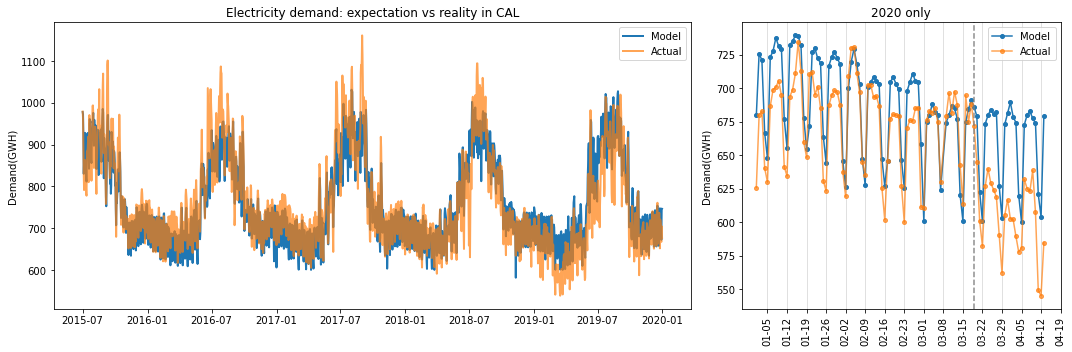

In [13]:
plot_model_region('CAL')

Score: 0.8339070234468339


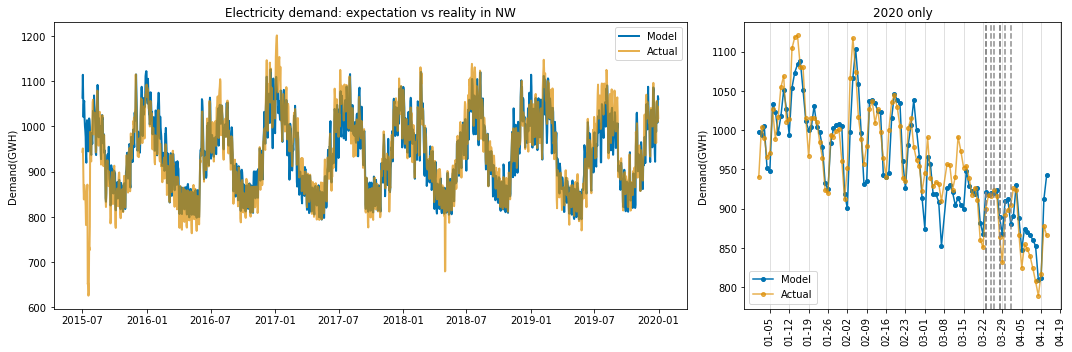

In [14]:
plot_model_region('NW')

Score: 0.8745454646643089


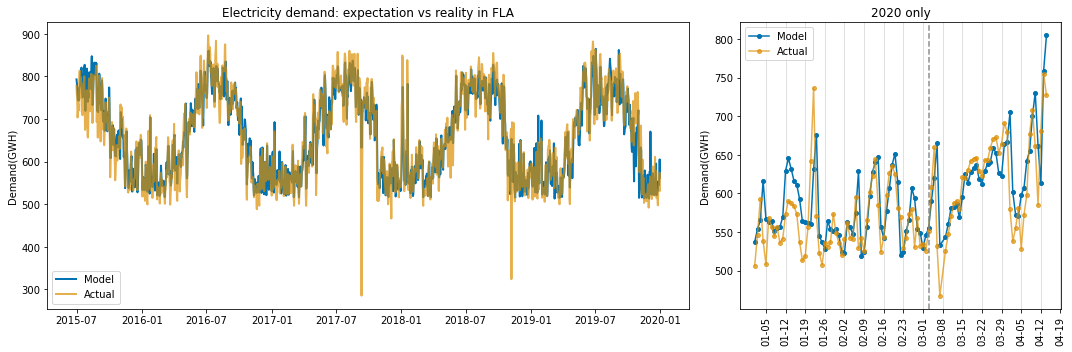

In [15]:
plot_model_region('FLA')

Score: 0.852123443686717


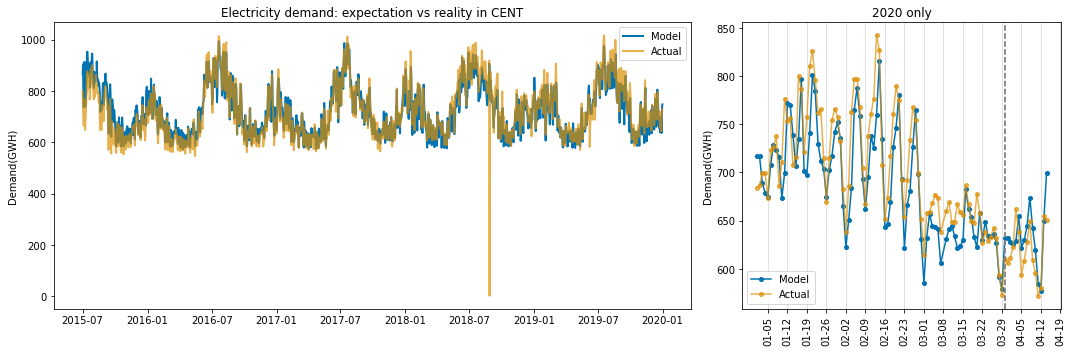

In [16]:
plot_model_region('CENT')

Score: 0.8776830236171104


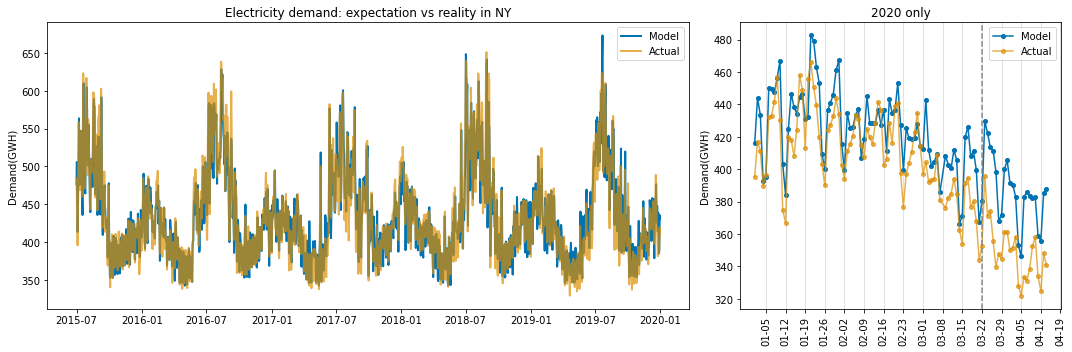

In [17]:
plot_model_region('NY')

Score: 0.8511848245283224


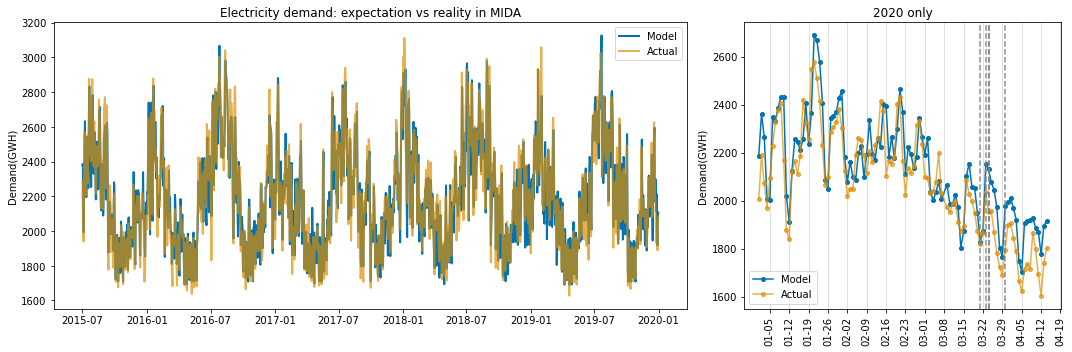

In [18]:
plot_model_region('MIDA')